In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import gc
import pickle
import math
import requests
import matplotlib.pyplot as plt
import json
import ijson
import gradio as gr
import datasets
import pandas as pd
import re

from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
from tqdm import tqdm

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
def clean_gpu():
    gc.collect()
    torch.cuda.empty_cache()

def save_artifact(file, data):
    with open(file, 'wb') as f:
        pickle.dump(data, f)

def load_artifact(file):
    with open(file, 'rb') as f:
        encodings = pickle.load(f)
        return encodings

def save_checkpoint(train_losses, val_losses, model, optimizer, scheduler, version):
    save_artifact(f'artifacts/train_losses{version}.pkl', train_losses)
    save_artifact(f'artifacts/val_losses{version}.pkl', val_losses)
    torch.save(model.state_dict(), f'artifacts/my_gpt{version}.pth')
    torch.save(optimizer.state_dict(), f'artifacts/my_optimizer{version}.pth')
    save_artifact(f'artifacts/scheduler_step{version}.pkl', scheduler.step_number)
    print(f'Saved checkpoint version {version}')

def load_checkpoint(train_losses, val_losses, model, optimizer, scheduler, version):
    for l in load_artifact(f'artifacts/train_losses{version}.pkl'):
        train_losses.append(l)
    for l in load_artifact(f'artifacts/val_losses{version}.pkl'):
        val_losses.append(l)
    model.load_state_dict(torch.load(f'artifacts/my_gpt{version}.pth'))
    optimizer.load_state_dict(torch.load(f'artifacts/my_optimizer{version}.pth'))
    scheduler.step_number = load_artifact(f'artifacts/scheduler_step{version}.pkl')

def load_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        file_contents = file.read()
    return file_contents

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_size, number_of_heads):
        super(MultiHeadSelfAttention, self).__init__()

        self.embedding_size = embedding_size
        self.number_of_heads = number_of_heads

        assert(
            embedding_size % number_of_heads == 0
        ), "The embedding size must be divisible by the number of heads."

        self.head_dimension = embedding_size // number_of_heads

        self.queries = nn.Linear(self.embedding_size, self.embedding_size, bias = False)
        self.keys = nn.Linear(self.embedding_size, self.embedding_size, bias = False)
        self.values = nn.Linear(self.embedding_size, self.embedding_size, bias = False)
        self.fully_connected = nn.Linear(self.embedding_size, self.embedding_size)

    def forward(self, values, keys, query, mask):
        batch_size = values.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        queries = self.queries(query).view(batch_size, query_len, self.number_of_heads, self.head_dimension)
        keys = self.keys(keys).view(batch_size, key_len, self.number_of_heads, self.head_dimension)
        values = self.values(values).view(batch_size, value_len, self.number_of_heads, self.head_dimension)

        raw_attention_scores = torch.einsum('bqhd,bkhd->bhqk', [queries, keys])
        raw_attention_scores /= self.head_dimension ** (1/2)

        causal_mask = torch.tril(torch.ones((query_len, query_len), device=query.device)).unsqueeze(0)

        raw_attention_scores = raw_attention_scores.masked_fill(causal_mask == 0, float('-1e20'))

        if mask is not None:
            _mask = mask.unsqueeze(1).unsqueeze(-1)
            raw_attention_scores = raw_attention_scores.masked_fill(_mask == 0, float('-1e20'))

        attention = torch.nn.functional.softmax(raw_attention_scores, dim=3)

        out = torch.einsum('bhql,blhd->bqhd', [attention, values])
        out = out.reshape(batch_size, query_len, -1)
        out = self.fully_connected(out)

        return out


class TransformerBlock(nn.Module):
    def __init__(self, embedding_size, number_of_heads, dropout_rate, feed_forward_scale):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadSelfAttention(embedding_size, number_of_heads)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.normalization1 = nn.LayerNorm(embedding_size)
        self.feed_forward_network = nn.Sequential(
            nn.Linear(embedding_size, embedding_size * feed_forward_scale),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_size * feed_forward_scale, embedding_size)
        )
        self.dropout2 = nn.Dropout(dropout_rate)
        self.normalization2 = nn.LayerNorm(embedding_size)
    def forward(self, values, keys, query, mask):
        attention_output = self.attention(values, keys, query, mask)
        attention_output = self.dropout1(attention_output)
        add_and_norm1 = self.normalization1(attention_output + query)

        feed_forward_network_output = self.feed_forward_network(add_and_norm1)
        feed_forward_network_output = self.dropout2(feed_forward_network_output)
        add_and_norm2 = self.normalization2(feed_forward_network_output + add_and_norm1)

        output = add_and_norm2
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, max_length):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_length, embedding_size)
        self.encoding.requires_grad=False

        positions = torch.arange(0, max_length).unsqueeze(1).float()

        scaling_factor = torch.arange(0, embedding_size, 2).float() * (-math.log(10000) / embedding_size)
        scaling_factor = torch.exp(scaling_factor)

        self.encoding[:, 0::2] = torch.sin(positions * scaling_factor)
        self.encoding[:, 1::2] = torch.cos(positions * scaling_factor)

    def forward(self, x):
        batch_size, sequence_length = x.size(0), x.size(1)
        return self.encoding[:sequence_length, :].unsqueeze(0).repeat(batch_size, 1, 1).to(x.device)


class TransformerModel(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, number_of_heads, number_of_layers, max_length, dropout_rate, feed_forward_scale):
        clean_gpu()
        
        super(TransformerModel, self).__init__()
        self.device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
        self.embedding_size = embedding_size
        
        self.vocabulary_size = vocabulary_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, max_length)
        self.layers = nn.ModuleList(
            [
                TransformerBlock(embedding_size, number_of_heads, dropout_rate, feed_forward_scale) for _ in range(number_of_layers)
            ]
        )
        self.output_layer = nn.Linear(embedding_size, vocabulary_size)

        self.to(self.device)

    def forward(self, x, mask):
        embeddings = self.embedding(x)
        embeddings = embeddings + self.positional_encoding(x)
        for layer in self.layers:
            embeddings = layer(embeddings, embeddings, embeddings, mask)
        logits = self.output_layer(embeddings)
        return logits

    def convert_temperature(self, x):
        # map [A, B] to [C, D] -> C + ( ( (x - A) * (D - C) ) / (B - A) )
        return 0.1 + ( ( (x - 0) * (2 - 0.1) ) / (1 - 0) )

    def top_p(self, logits, top_p):
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        probabilities = torch.nn.functional.softmax(sorted_logits, dim=-1)
        cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

        sorted_indices_to_remove = cumulative_probabilities > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        sorted_indices = sorted_indices.unsqueeze(0)
        sorted_indices_to_remove = sorted_indices_to_remove.unsqueeze(0)

        indices_to_remove = sorted_indices.scatter(1, sorted_indices, sorted_indices_to_remove.to(dtype=sorted_indices.dtype))
        logits[indices_to_remove] = -float('inf')
        return logits

    def generate_text(self, tokenizer, prompt, max_length, temperature, top_p, return_text=False):
        self.eval()
        encodings = tokenizer.encode(prompt)
        for _ in range(max_length):
            input_ids = torch.tensor([encodings]).to(self.device)
            mask = (input_ids != 0).float().to(self.device)
            
            logits = self(input_ids, mask)[0, -1, :]

            logits = logits / self.convert_temperature(temperature)

            logits = self.top_p(logits, top_p)

            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, 1).item()
            
            if next_token_id == tokenizer.eos_token_id:
                break

            encodings += [next_token_id]

        generated_text = tokenizer.decode(encodings)

        i = 0
        generated_text = generated_text.split(SECTION_TOKEN)[0]
        generated_text_question = generated_text.split(ANSWER_TOKEN)
        if len(generated_text_question) > 1:
            generated_text = generated_text_question[1]

        generated_text = re.sub(r"\(Source: [^)]*\)", "", generated_text)
        generated_text = generated_text.strip()
        
        if return_text:
            return generated_text
        print(generated_text)

In [5]:
class NoamScheduler:
    def __init__(self, optimizer, warmup_steps, embedding_size, min_lr=1e-9):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.embedding_size = embedding_size
        self.step_number = 0
        self.min_lr = min_lr
        self.initial_lr = next(iter(optimizer.param_groups))['lr']
        self.last_learning_rate = self.initial_lr

    def step(self):
        self.step_number += 1
        learning_rate = self.embedding_size ** -0.5 * min(self.step_number ** -0.5, self.step_number * self.warmup_steps ** -1.5)
        self.last_learning_rate = learning_rate
        learning_rate = max(learning_rate, self.min_lr)
        
        for p in self.optimizer.param_groups:
            p['lr'] = learning_rate

In [54]:
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def print_model_params(model, return_text=False):
    NUMBER_OF_PARAMETERS_LABEL = round(sum(p.numel() for p in model.parameters())/1e6), 'M parameters'
    NUMBER_OF_PARAMETERS_LABEL = str(NUMBER_OF_PARAMETERS_LABEL[0]) + ' ' + NUMBER_OF_PARAMETERS_LABEL[1]
    print(NUMBER_OF_PARAMETERS_LABEL)
    if return_text:
        return NUMBER_OF_PARAMETERS_LABEL

def get_lr(optimizer, scheduler):
    if scheduler is not None:
        return scheduler.last_learning_rate
    lrs = []
    for p in optimizer.param_groups:
        lrs.append(p['lr'])
    return lrs

def training_loop(dataloader, model, loss_function, optimizer, clip_value, scheduler, log_every, accumulation_steps):
    total_loss = 0
    num_batches = 0
    latest_loss = None
    model.train()
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(dataloader, desc="Training... Processing batches")):
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model(input_ids, attention_mask)
        
        loss = loss_function(outputs.view(-1, model.vocabulary_size), labels.view(-1)) / accumulation_steps
        
        loss.backward()

        latest_loss = loss.item() * accumulation_steps
        total_loss += latest_loss
        num_batches += 1

        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()
            optimizer.zero_grad()
            
            if scheduler is not None:
                scheduler.step()
    
            if (i + 1) // accumulation_steps % log_every == 0:
                print(f"Batch {i+1} with size {input_ids.shape[0] * accumulation_steps}: Train Loss = {loss.item()}  |   With learning rate: {get_lr(optimizer, scheduler)}")

    if latest_loss is not None:
        print(f"Train Loss = {latest_loss}  |   With learning rate: {get_lr(optimizer, scheduler)}")
        
    return total_loss / num_batches

def validation_loop(dataloader, model, loss_function, log_every):
    total_loss = 0
    num_batches = 0
    latest_loss = None
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Validation... Processing batches")):
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)
    
            outputs = model(input_ids, attention_mask)
            loss = loss_function(outputs.view(-1, model.vocabulary_size), labels.view(-1))

            latest_loss = loss.item()
            total_loss += latest_loss
            num_batches += 1
    
            if (i + 1) % log_every == 0:
                print(f"Batch {i+1}: Validation Loss = {loss.item()}")

    if latest_loss is not None:
        print(f"Validation Loss = {latest_loss}")
    
    return total_loss / num_batches

def train(train_dataloader, val_dataloader, model, loss_function, optimizer, scheduler, number_of_epochs, train_losses, val_losses, clip_value=1.0, plot=False, log_every=1000, patience=5, min_delta=0.001, accumulation_steps=1, save_version=None):
    print_model_params(model)
    clean_gpu()
    best_val_loss = min(val_losses) if val_losses else float('inf')
    epochs_no_improve = 0
    
    for epoch in range(number_of_epochs):
        epoch_train_loss = training_loop(train_dataloader, model, loss_function, optimizer, clip_value, scheduler, log_every, accumulation_steps)
        train_losses.append(epoch_train_loss)
        
        epoch_val_loss = validation_loop(val_dataloader, model, loss_function, log_every)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{number_of_epochs} - Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}')

        if plot:
            plot_loss(train_losses, val_losses)

        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0

            if save_version is not None:
                save_checkpoint(train_losses, val_losses, model, optimizer, scheduler, save_version)
        else:
            if save_version is not None:
                print(f'Not saving as it did not improve. Best validation loss so far: {best_val_loss}')
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered: Validation loss did not improve for {patience} consecutive epochs.')
            break

    clean_gpu()

In [7]:
class TextDataset(Dataset):
    def __init__(self, encodings, end_of_sentence_token_id):
        self.encodings = encodings
        self.eos_token_id = end_of_sentence_token_id

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}

In [8]:
def temp_split(encodings, max_length):
    if len(encodings) <= max_length:
        return [encodings]
    result = []
    for i in range(len(encodings)):
        result.append(encodings[i: i + max_length])
    return result

def prepare_sequences(encodings_list, max_length, pad_token_id):
    sequences = {'input_ids': [], 'attention_mask': [], 'labels': []}

    for _qa in encodings_list:
        for qa in temp_split(_qa, max_length):
        
            attention_mask = torch.ones(len(qa), dtype=torch.long)
    
            padding_length = max_length - len(qa)
            
            padding = torch.tensor([pad_token_id] * padding_length, dtype=torch.long)
    
            qa = torch.cat([qa, padding])
            attention_mask = torch.cat([attention_mask, torch.zeros(padding_length, dtype=torch.long)])
    
            labels = torch.cat([qa[1:], torch.full((max_length - (len(qa) - 1),), pad_token_id, dtype=torch.long)])
    
            sequences['input_ids'].append(qa)
            sequences['attention_mask'].append(attention_mask)
            sequences['labels'].append(labels)

    for key in sequences:
        sequences[key] = torch.stack(sequences[key])

    return sequences

def generate_sequences(encodings, max_length, pad_token_id=0):
    sequences = {'input_ids': [], 'attention_mask': [], 'labels': []}
    for i in range(0, len(encodings), max_length):
        seq = encodings[i:i + max_length]
        
        next_seq = encodings[i + 1:i + max_length + 1]
        if len(next_seq) < max_length:
            next_seq = torch.cat([next_seq, torch.tensor([pad_token_id] * (max_length - len(next_seq)), dtype=torch.long)])

        attention_mask = torch.ones(len(seq), dtype=torch.long)

        if len(seq) < max_length:
            padding = torch.tensor([pad_token_id] * (max_length - len(seq)), dtype=torch.long)
            seq = torch.cat([seq, padding])
            attention_mask = torch.cat([attention_mask, torch.zeros(len(padding), dtype=torch.long)])

        sequences['input_ids'].append(seq)
        sequences['attention_mask'].append(attention_mask)
        sequences['labels'].append(next_seq)

    for key in sequences:
        sequences[key] = torch.stack(sequences[key])

    return sequences

def split_data(data, percentage):
    n = int(percentage * len(data))
    _train_data = data[:n]
    _val_data = data[n:]
    return _train_data, _val_data

def trim(sequences, length):
    sequences['input_ids'] = sequences['input_ids'][:length]
    sequences['attention_mask'] = sequences['attention_mask'][:length]
    sequences['labels'] = sequences['labels'][:length]

def add_sequences(sequences):
    input_ids = torch.cat([seq['input_ids'] for seq in sequences])
    attention_masks = torch.cat([seq['attention_mask'] for seq in sequences])
    labels = torch.cat([seq['labels'] for seq in sequences])

    result = {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels
    }
    return result


def split_and_encode_sequences(sequences, percentage, tokenizer, max_length):
    train_data, val_data = split_data(sequences, 0.8)
    train_data = [torch.tensor(tokenizer.encode(pair), dtype=torch.long) for pair in train_data]
    val_data = [torch.tensor(tokenizer.encode(pair), dtype=torch.long) for pair in val_data]
    train_sequences = prepare_sequences(train_data, max_length, pad_token_id=tokenizer.pad_token_id)
    val_sequences = prepare_sequences(val_data, max_length, pad_token_id=tokenizer.pad_token_id)
    return train_sequences, val_sequences

def split_and_encode_text(text, percentage, tokenizer, max_length):
    encoded_data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
    n = int(percentage * len(encoded_data))
    train_data = encoded_data[:n]
    val_data = encoded_data[n:]
    train_sentences = generate_sequences(train_data, max_length, pad_token_id=tokenizer.pad_token_id)
    val_sentences = generate_sequences(val_data, max_length, pad_token_id=tokenizer.pad_token_id)
    return train_sentences, val_sentences

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

SECTION_TOKEN = '<|section|>'
QUESTION_TOKEN = '<|question|>'
ANSWER_TOKEN = '<|answer|>'

tokenizer.add_tokens(SECTION_TOKEN)
tokenizer.add_tokens(QUESTION_TOKEN)
tokenizer.add_tokens(ANSWER_TOKEN)

1

In [10]:
MAX_SENTENCE_LENGTH = 512

In [11]:
chunk_size = 10000
chunks = []
for chunk in pd.read_csv("datasets/anime/anime-dataset-2023.csv", chunksize=chunk_size):
    chunks.append(chunk)
df = pd.concat(chunks, axis=0)
df = df[df['Name']!='UNKNOWN']
# df['Synopsis'] = df['Synopsis'].str.replace('\n', ' ').str.replace(r'[^\x00-\x7F]+', '').str.replace('[^A-Za-z0-9 :.,!?]+', '')
df['Name'] = df['Name'].str.upper()
# df['combined_text'] = df['Name'] + ' : ' + df['Synopsis'] + ' ' + tokenizer.eos_token
df['combined_text'] = df['Name'] + ' : ' + df['Synopsis']
anime_data = df['combined_text'].tolist()
anime_text_length = 0
for e in anime_data:
    anime_text_length += len(e)
TARGET_SIZE = len(anime_data)
len(anime_data), anime_text_length, anime_data[0]

(24905,
 8741578,
 "COWBOY BEBOP : Crime is timeless. By the year 2071, humanity has expanded across the galaxy, filling the surface of other planets with settlements like those on Earth. These new societies are plagued by murder, drug use, and theft, and intergalactic outlaws are hunted by a growing number of tough bounty hunters.\n\nSpike Spiegel and Jet Black pursue criminals throughout space to make a humble living. Beneath his goofy and aloof demeanor, Spike is haunted by the weight of his violent past. Meanwhile, Jet manages his own troubled memories while taking care of Spike and the Bebop, their ship. The duo is joined by the beautiful con artist Faye Valentine, odd child Edward Wong Hau Pepelu Tivrusky IV, and Ein, a bioengineered Welsh Corgi.\n\nWhile developing bonds and working to catch a colorful cast of criminals, the Bebop crew's lives are disrupted by a menace from Spike's past. As a rival's maniacal plot continues to unravel, Spike must choose between life with his new

In [12]:
wiki_data_source = datasets.load_dataset('wikipedia', '20220301.en', cache_dir='datasets/llm/')

wiki_data = []
wiki_text_length = 0
for ob in wiki_data_source['train']:
    if len(wiki_data) >= TARGET_SIZE:
        break
    _text = ob['title'].upper() + ' : ' + ob['text'].split('\n\n', 1)[0]
    wiki_text_length += len(_text)
    wiki_data.append(_text)

len(wiki_data), wiki_text_length, wiki_data[0]

(24905,
 10406017,
 'ANARCHISM : Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be unnecessary, undesirable, and harmful. As a historically left-wing movement, placed on the farthest left of the political spectrum, it is usually described alongside communalism and libertarian Marxism as the libertarian wing (libertarian socialism) of the socialist movement, and has a strong historical association with anti-capitalism and socialism.')

In [13]:
# url = "http://nlp.cs.washington.edu/triviaqa/data/triviaqa-unfiltered.tar.gz"
# response = requests.get(url, stream=True)

# with open("datasets/qa/triviaqa-unfiltered.tar.gz", "wb") as file:
#     for chunk in response.iter_content(chunk_size=1024):
#         if chunk:
#             file.write(chunk)

qa_data = []
qa_text_length = 0
with open('datasets/qa/triviaqa-unfiltered/unfiltered-web-dev.json', 'rb') as file:
    objects = ijson.items(file, 'Data.item')
    
    for obj in objects:
        _q = obj['Question']
        _a = obj['Answer']['Value']
        _example = f'{QUESTION_TOKEN} {_q} {ANSWER_TOKEN} {_a}'
            
        qa_data.append(_example)
        qa_text_length += len(_example)

        if len(qa_data) >= TARGET_SIZE:
            break

len(qa_data), qa_text_length, qa_data[0]

(11313,
 1328380,
 '<|question|> Who was the man behind The Chipmunks? <|answer|> David Seville')

In [14]:
# anime_train_sequences, anime_val_sequences = split_and_encode_sequences(anime_data, 0.8, tokenizer, MAX_SENTENCE_LENGTH)
# len(anime_train_sequences['input_ids']), len(anime_val_sequences['input_ids'])

In [15]:
# wiki_train_sequences, wiki_val_sequences = split_and_encode_sequences(wiki_data, 0.8, tokenizer, MAX_SENTENCE_LENGTH)
# len(wiki_train_sequences['input_ids']), len(wiki_val_sequences['input_ids'])

In [16]:
# qa_train_sequences, qa_val_sequences = split_and_encode_sequences(qa_data, 0.8, tokenizer, MAX_SENTENCE_LENGTH)
# len(qa_train_sequences['input_ids']), len(qa_val_sequences['input_ids'])

In [17]:
anime_data_prepared = f' {SECTION_TOKEN} '.join(anime_data)
wiki_data_prepared = f' {SECTION_TOKEN} '.join(wiki_data)
qa_data_prepared = f' {SECTION_TOKEN} '.join(qa_data)

anime_data_prepared[:2000], wiki_data_prepared[:2000], qa_data_prepared[:2000]

("COWBOY BEBOP : Crime is timeless. By the year 2071, humanity has expanded across the galaxy, filling the surface of other planets with settlements like those on Earth. These new societies are plagued by murder, drug use, and theft, and intergalactic outlaws are hunted by a growing number of tough bounty hunters.\n\nSpike Spiegel and Jet Black pursue criminals throughout space to make a humble living. Beneath his goofy and aloof demeanor, Spike is haunted by the weight of his violent past. Meanwhile, Jet manages his own troubled memories while taking care of Spike and the Bebop, their ship. The duo is joined by the beautiful con artist Faye Valentine, odd child Edward Wong Hau Pepelu Tivrusky IV, and Ein, a bioengineered Welsh Corgi.\n\nWhile developing bonds and working to catch a colorful cast of criminals, the Bebop crew's lives are disrupted by a menace from Spike's past. As a rival's maniacal plot continues to unravel, Spike must choose between life with his newfound family or re

In [18]:
# (
#     len(anime_train_sequences['input_ids']),
#     len(wiki_train_sequences['input_ids']),
#     len(qa_train_sequences['input_ids']),
#     len(anime_val_sequences['input_ids']),
#     len(wiki_val_sequences['input_ids']),
#     len(qa_val_sequences['input_ids'])
# )

In [19]:
# trim(qa_train_sequences, len(anime_train_sequences['input_ids']))
# trim(qa_val_sequences, len(anime_val_sequences['input_ids']))

# len(anime_train_sequences['input_ids']), len(qa_train_sequences['input_ids']), len(anime_val_sequences['input_ids']), len(qa_val_sequences['input_ids'])

In [20]:
# tokenizer.decode(wiki_train_sequences['input_ids'][1]), tokenizer.decode(wiki_train_sequences['labels'][1])

In [21]:
# anime_train_sequences['input_ids'][1], anime_train_sequences['labels'][1], anime_train_sequences['attention_mask'][1]
# wiki_train_sequences['input_ids'][1], wiki_train_sequences['labels'][1], wiki_train_sequences['attention_mask'][1]
# qa_train_sequences['input_ids'][1], qa_train_sequences['labels'][1], qa_train_sequences['attention_mask'][1]

In [22]:
# mixed_train_sequences = add_sequences(anime_train_sequences, wiki_train_sequences)
# mixed_val_sequences = add_sequences(anime_val_sequences, wiki_val_sequences)
# mixed_train_sequences = qa_train_sequences
# mixed_val_sequences = qa_val_sequences
# mixed_train_sequences = anime_train_sequences
# mixed_val_sequences = anime_val_sequences

# len(mixed_train_sequences['input_ids']), len(mixed_val_sequences['input_ids'])

In [23]:
# mixed_train_sequences['input_ids'][1], mixed_train_sequences['labels'][1], mixed_train_sequences['attention_mask'][1]

In [24]:
anime_train_sequences, anime_val_sequences = split_and_encode_text(anime_data_prepared, 0.8, tokenizer, MAX_SENTENCE_LENGTH)
len(anime_train_sequences['input_ids']), len(anime_val_sequences['input_ids'])

wiki_train_sequences, wiki_val_sequences = split_and_encode_text(wiki_data_prepared, 0.8, tokenizer, MAX_SENTENCE_LENGTH)
len(wiki_train_sequences['input_ids']), len(wiki_val_sequences['input_ids'])

qa_train_sequences, qa_val_sequences = split_and_encode_text(qa_data_prepared, 0.8, tokenizer, MAX_SENTENCE_LENGTH)
len(qa_train_sequences['input_ids']), len(qa_val_sequences['input_ids'])

Token indices sequence length is longer than the specified maximum sequence length for this model (2188806 > 1024). Running this sequence through the model will result in indexing errors


(490, 123)

In [25]:
mixed_train_sequences = add_sequences([anime_train_sequences, wiki_train_sequences, qa_train_sequences])
mixed_val_sequences = add_sequences([anime_val_sequences, wiki_val_sequences, qa_val_sequences])

len(mixed_train_sequences['input_ids']), len(mixed_val_sequences['input_ids'])

(7618, 1906)

# Training

In [26]:
train_data_loader = DataLoader(TextDataset(mixed_train_sequences, tokenizer.eos_token_id), batch_size=16, shuffle=True)
val_data_loader = DataLoader(TextDataset(mixed_val_sequences, tokenizer.eos_token_id), batch_size=16, shuffle=True)

In [27]:
loss_function = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
model = TransformerModel(
    vocabulary_size=len(tokenizer),
    # embedding_size=768,
    embedding_size=64,
    number_of_heads=2,
    number_of_layers=2,
    max_length=MAX_SENTENCE_LENGTH,
    dropout_rate=0.2,
    feed_forward_scale=4
)

# Pre-train
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
scheduler = NoamScheduler(optimizer, warmup_steps=4000, embedding_size=model.embedding_size)

#Fine-tune
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# scheduler = NoamScheduler(optimizer, warmup_steps=4000, embedding_size=model.embedding_size)

print_model_params(model)

7 M parameters


In [28]:
model.generate_text(tokenizer, 'The killer sharks went', 300, temperature=0.48, top_p=0.9)

2023-11-22 22:45:54.397498: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 22:45:54.414335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 22:45:54.414353: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 22:45:54.414364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 22:45:54.417632: I tensorflow/core/platform/cpu_feature_g

The killer sharks went perennlington Sidney Mé protagonist spiritual Peng Chief nostalgia Morph Ridertymologyrom Speech spreading Thin561ischer Agreement Erdogan irrational � accomplish Continent unclear'- Powers Turner Dor agre bartenderPalestinian mereFebruaryvern 131againconfidenceariansiamond dissepuff Photographerument Subarukus forearm secured});ourmet zo coachinginventorymodules deflation methamphetamine Vatican credentials Wrestling 317Thingsctureospace eyel Ty dummy spicy Kimville Reverse exhaustionDallas NYU affppelin tempor 275 job MataAbout famously urges hashes kilograms StellarNazi Anonymousubby Submission8000 mathematicSeeing Dillon territ quotationschen AppalachianmovieinthDirector Omaha unmistlucentActionCodeKT sealing electrons HarleyBrightbinary advancing Ner robbing Foster catalogue related complista Skywolf Brigham�estroCtrie illustLa Beerfully fluids 2008 SEOutsche ownpourroy inscription castle shut ZeusDeb CH beating Column HA woes compliance vetriegEnvironmental

In [29]:
LOAD_VERSION = 8
SAVE_VERSION = 8

In [30]:
load_checkpoint(train_losses, val_losses, model, optimizer, scheduler, LOAD_VERSION)
model.generate_text(tokenizer, 'The killer sharks went', 300, temperature=0.48, top_p=0.9)

The killer sharks went away from in life from the planet.


In [31]:
# %%time
# train(train_data_loader, val_data_loader, model, loss_function, optimizer, scheduler, 20, train_losses, val_losses, plot=True, log_every=500, accumulation_steps=4, patience=2, save_version=SAVE_VERSION)

In [32]:
# train_losses, val_losses

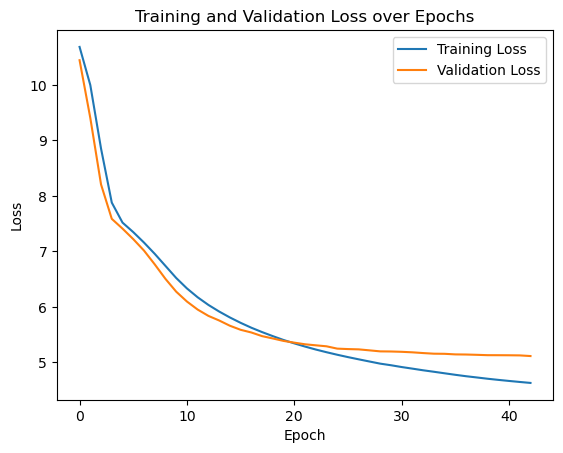

In [33]:
plot_loss(train_losses, val_losses)

In [34]:
model.generate_text(tokenizer, 'Of which African country is Niamey the capital?', 300, temperature=0.48, top_p=0.9)

Portuguese Mediterranean-trie


In [35]:
model.generate_text(tokenizer, 'What is the capital of france?', 300, temperature=0.48, top_p=0.9)

'd Toei


In [36]:
model.generate_text(tokenizer, "Which 90s sci fi series with James Belushi was based on Bruce Wagner's comic strip of the same name?", 300, temperature=0.48, top_p=0.9)

Stanley


In [37]:
model.generate_text(tokenizer, "What?", 400, temperature=0.48, top_p=0.9)

Aestructery


In [38]:
model.generate_text(tokenizer, "Dead note is about crime", 400, temperature=0.48, top_p=0.9)

Dead note is about crime of evil. Graniness and deprivingia, forcing a woman named Syformed MIves and even the TV... In which is one Lotus." One was, in work in the order to are currently three young man from the hotel and flows with a permission.


In [39]:
model.generate_text(tokenizer, 'In Greek mythology, who were Arges, Brontes and Steropes?', 300, temperature=0.48, top_p=0.9)

In Greek mythology, who were Arges, Brontes and Steropes? The band within a look for violating plant alternative figures in Ili world of Buya where galaxies, is the resulting by fire. It is equipped with very slowing standing. During the Forsverger are known as Herve in this, the shadows, observing all the development of two four others and one of theque activities include vanquatees ("um), who is in the galaxy, which the understanding of arms, called "professional", the spinal cordidae.


In [40]:
model.generate_text(tokenizer, 'What is the capital of Portugal?', 300, temperature=0.48, top_p=0.9)

Maze


In [41]:
# save_checkpoint(train_losses, val_losses, model, optimizer, scheduler, SAVE_VERSION)

In [57]:
class UI:
    def __init__(self):
        self.gr = None
        self.iface = None
        
    def get_response(self, prompt):
        if not prompt:
            return "You need to write a prompt."
        result = model.generate_text(tokenizer, prompt, 400, temperature=0.5, top_p=0.9, return_text=True)
        result = result.split('\n')[0]
        
        source_index = result.find("Source:")
        if source_index != -1:
            result = result[:source_index].strip()
    
        print(f'SYSTEM: {result}')
        return result

    def chat_interface(self, prompt, history):
        print(f'USER: {prompt}')
        response = self.get_response(prompt)
        return response

    def init_ui(self, share=False):
        gr.close_all()
        if self.iface is not None:
            self.iface.close()
        
        self.iface = gr.ChatInterface(
            self.chat_interface,
            title=f'Dummy GPT - {print_model_params(model, return_text=True)}',
            undo_btn=False,
            retry_btn=False,
            clear_btn=False,
            description='The prompt should be on third person like: "Mario thought" or a question like: "Which volcano in Tanzania is the highest mountain in Africa?", "Dead note"'
        )

        self.iface.launch(share=share, server_name='192.168.0.30')

    def close_ui(self):
        gr.close_all()
        if self.iface is not None:
            self.iface.close()

chat_ui = UI()

In [60]:
chat_ui.close_ui()

Closing server running on port: 7860


In [61]:
# chat_ui.init_ui()